In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import geopandas as gpd


In [3]:
# Your inputs:
road_gdf = gpd.read_file("/kaggle/input/undetected/Streets.shp")  # Your road network
detected_roundabouts_gdf = gpd.read_file("/kaggle/input/detected1/detected_roundabouts.shp")  # Your detected roundabouts

# Make sure column names match
print("Detected roundabouts columns:", detected_roundabouts_gdf.columns.tolist())
print("First few rows:")
print(detected_roundabouts_gdf.head())

Detected roundabouts columns: ['label', 'geometry']
First few rows:
                 label                                           geometry
0  Detected Roundabout  POLYGON ((26.68916 57.19614, 26.68995 57.19599...
1  Detected Roundabout  POLYGON ((26.69093 57.19574, 26.69034 57.19591...
2  Detected Roundabout  POLYGON ((26.69333 57.19400, 26.69386 57.19451...
3  Detected Roundabout  POLYGON ((26.61219 57.26251, 26.61211 57.26248...
4  Detected Roundabout  POLYGON ((26.58808 57.28491, 26.58919 57.28454...


Loaded 494821 road segments
Loaded 38300 detected roundabouts
Filtering 38300 detected roundabouts...

Filtering Results:
Valid roundabouts: 5185
Rejected roundabouts: 33115


/tmp/ipykernel_35/467925285.py:336: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  final_roundabouts_gdf.to_file("filtered_valid_roundabouts1.shp")



Saved 5185 valid roundabouts to 'filtered_valid_roundabouts1.shp'
Saved 33115 rejected roundabouts to 'rejected_roundabouts1.shp'

=== FILTERING STATISTICS ===
Total detected: 38300
Valid: 5185 (13.5%)
Rejected: 33115 (86.5%)

Valid Roundabouts Summary:
Diameter range: 15.3m - 399.7m
Average diameter: 113.3m
Road connections: 6 - 29 roads


AttributeError: You are calling a geospatial method on the GeoDataFrame, but the active geometry column to use has not been set. 
There are no existing columns with geometry data type. You can add a geometry column as the active geometry column with df.set_geometry. 

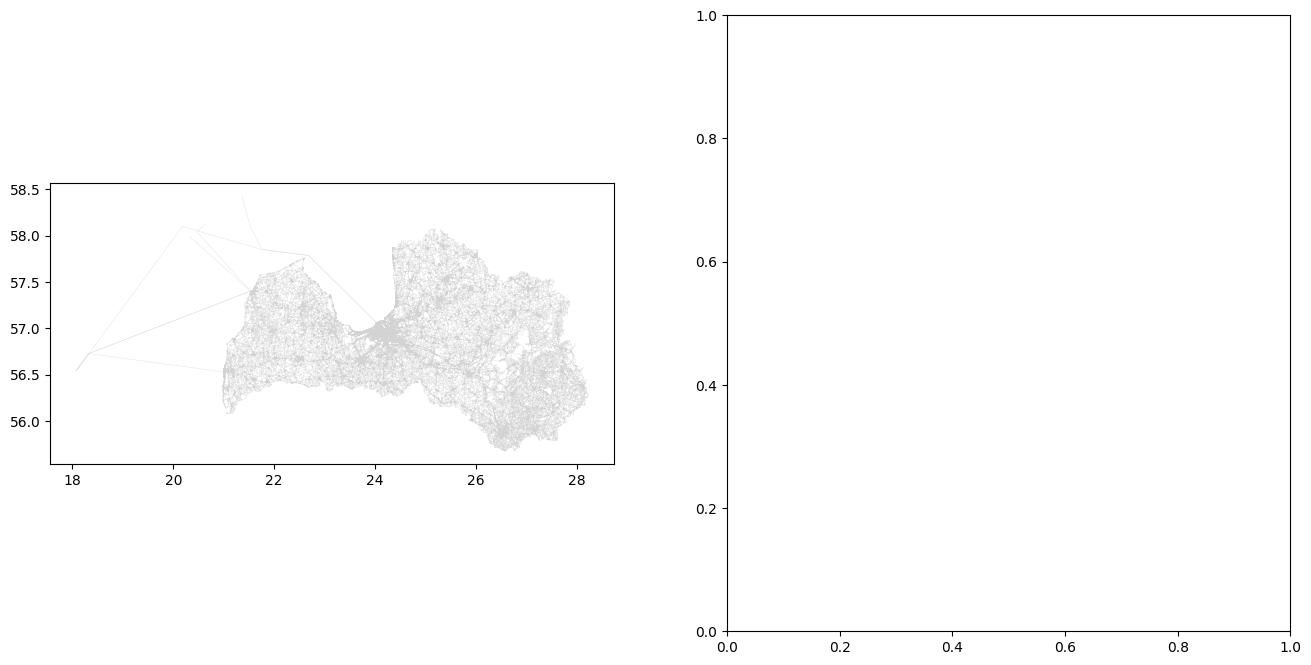

In [7]:
import geopandas as gpd
import networkx as nx
from shapely.geometry import LineString, Point, Polygon, MultiPoint
from shapely.ops import nearest_points
import numpy as np
import math
from scipy.spatial.distance import cdist
from collections import Counter

def calculate_roundabout_metrics(polygon):
    """Calculate various geometric metrics for roundabout validation"""
    try:
        # Basic measurements
        area = polygon.area  # in square degrees, convert to meters if needed
        perimeter = polygon.length
        centroid = polygon.centroid
        
        # Convert to approximate meters (rough conversion for EPSG:4326)
        # 1 degree ≈ 111,000 meters at equator
        area_m2 = area * (111000 ** 2)
        perimeter_m = perimeter * 111000
        
        # Diameter estimation
        diameter_m = math.sqrt(4 * area_m2 / math.pi)
        
        # Compactness (circularity)
        compactness = (4 * math.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
        
        # Aspect ratio using bounding box
        bounds = polygon.bounds
        width = (bounds[2] - bounds[0]) * 111000  # convert to meters
        height = (bounds[3] - bounds[1]) * 111000
        aspect_ratio = min(width, height) / max(width, height) if max(width, height) > 0 else 0
        
        return {
            'area_m2': area_m2,
            'perimeter_m': perimeter_m,
            'diameter_m': diameter_m,
            'compactness': compactness,
            'aspect_ratio': aspect_ratio,
            'centroid': centroid
        }
    except:
        return None

def count_connecting_roads(roundabout_polygon, road_lines, buffer_distance=0.0005):
    """Count roads that connect to the roundabout perimeter"""
    try:
        # Create a buffer around the roundabout to catch nearby roads
        buffered_roundabout = roundabout_polygon.buffer(buffer_distance)
        
        # Find roads that intersect with the buffer
        connecting_roads = []
        connection_points = []
        
        for idx, road in road_lines.iterrows():
            if road.geometry.intersects(buffered_roundabout):
                # Check if road actually connects to the roundabout boundary
                intersection = road.geometry.intersection(roundabout_polygon.boundary)
                if not intersection.is_empty:
                    connecting_roads.append(road)
                    # Get connection points
                    if hasattr(intersection, 'geoms'):
                        for geom in intersection.geoms:
                            if isinstance(geom, Point):
                                connection_points.append(geom)
                    elif isinstance(intersection, Point):
                        connection_points.append(intersection)
        
        return len(connecting_roads), connection_points, connecting_roads
    except:
        return 0, [], []

def analyze_connection_distribution(connection_points, roundabout_centroid):
    """Analyze if connection points are well distributed around the roundabout"""
    if len(connection_points) < 3:
        return False, 0
    
    try:
        # Calculate angles of connection points relative to centroid
        angles = []
        for point in connection_points:
            dx = point.x - roundabout_centroid.x
            dy = point.y - roundabout_centroid.y
            angle = math.atan2(dy, dx)
            angles.append(angle)
        
        # Sort angles
        angles.sort()
        
        # Calculate angular differences
        angle_diffs = []
        for i in range(len(angles)):
            diff = angles[(i + 1) % len(angles)] - angles[i]
            if diff < 0:
                diff += 2 * math.pi
            angle_diffs.append(diff)
        
        # Check distribution (should not have huge gaps)
        max_gap = max(angle_diffs)
        avg_gap = sum(angle_diffs) / len(angle_diffs)
        
        # Well distributed if no gap is more than 2x the average
        is_well_distributed = max_gap < 2 * avg_gap and max_gap < math.pi
        
        return is_well_distributed, max_gap
    except:
        return False, 0

def filter_roundabouts(roundabout_candidates, road_gdf):
    """Filter roundabout candidates based on multiple criteria"""
    
    validated_roundabouts = []
    
    for i, roundabout in enumerate(roundabout_candidates):
        # Calculate metrics
        metrics = calculate_roundabout_metrics(roundabout)
        if not metrics:
            continue
        
        # Size constraints (typical roundabout sizes)
        diameter_ok = 15 <= metrics['diameter_m'] <= 400  # 15m to 150m diameter
        area_ok = 180 <= metrics['area_m2'] <= 125600  # Corresponding areas
        
        # Geometric constraints
        circular_enough = metrics['compactness'] > 0.4  # Should be reasonably circular
        not_elongated = metrics['aspect_ratio'] > 0.6   # Not too elongated
        
        # Road connectivity
        num_roads, connection_points, connecting_roads = count_connecting_roads(
            roundabout, road_gdf
        )
        
        enough_connections = num_roads >= 3  # At least 3 connecting roads
        
        # Connection distribution
        well_distributed, max_gap = analyze_connection_distribution(
            connection_points, metrics['centroid']
        )
        
        # Combined criteria
        is_valid_roundabout = (
            diameter_ok and 
            area_ok and 
            circular_enough and 
            not_elongated and 
            enough_connections and 
            well_distributed
        )
        
        # Store results
        result = {
            'geometry': roundabout,
            'diameter_m': metrics['diameter_m'],
            'area_m2': metrics['area_m2'],
            'compactness': metrics['compactness'],
            'aspect_ratio': metrics['aspect_ratio'],
            'num_connecting_roads': num_roads,
            'well_distributed': well_distributed,
            'max_angular_gap': max_gap,
            'is_valid': is_valid_roundabout,
            'connecting_roads': connecting_roads
        }
        
        validated_roundabouts.append(result)
    
    return validated_roundabouts

# Function to filter your existing detected roundabouts
def filter_existing_roundabouts(detected_roundabouts_gdf, road_gdf):
    """Filter already detected roundabout polygons based on validation criteria"""
    
    validated_roundabouts = []
    
    print(f"Filtering {len(detected_roundabouts_gdf)} detected roundabouts...")
    
    for idx, row in detected_roundabouts_gdf.iterrows():
        roundabout_polygon = row.geometry
        
        # Skip invalid geometries
        if not roundabout_polygon.is_valid:
            continue
            
        # Calculate metrics
        metrics = calculate_roundabout_metrics(roundabout_polygon)
        if not metrics:
            continue
        
        # Size constraints (typical roundabout sizes)
        diameter_ok = 15 <= metrics['diameter_m'] <= 400  # 15m to 150m diameter
        area_ok = 180 <= metrics['area_m2'] <= 125600  # Corresponding areas
        
        # Geometric constraints
        circular_enough = metrics['compactness'] > 0.4  # Should be reasonably circular
        not_elongated = metrics['aspect_ratio'] > 0.6   # Not too elongated
        
        # Road connectivity - find roads near this roundabout
        buffer_distance = 0.001  # Adjust based on your data precision
        nearby_roads = road_gdf[road_gdf.intersects(roundabout_polygon.buffer(buffer_distance))]
        
        # Road connectivity
        num_roads, connection_points, connecting_roads = count_connecting_roads(
            roundabout_polygon, nearby_roads
        )
        
        enough_connections = num_roads >= 3  # At least 3 connecting roads
        
        # Connection distribution
        well_distributed, max_gap = analyze_connection_distribution(
            connection_points, metrics['centroid']
        )
        
        # Combined criteria
        is_valid_roundabout = (
            diameter_ok and 
            area_ok and 
            circular_enough and 
            not_elongated and 
            enough_connections and 
            well_distributed
        )
        
        # Store results with original index
        result = {
            'original_index': idx,
            'geometry': roundabout_polygon,
            'diameter_m': metrics['diameter_m'],
            'area_m2': metrics['area_m2'],
            'compactness': metrics['compactness'],
            'aspect_ratio': metrics['aspect_ratio'],
            'num_connecting_roads': num_roads,
            'well_distributed': well_distributed,
            'max_angular_gap': max_gap,
            'is_valid': is_valid_roundabout,
            'rejection_reasons': get_rejection_reasons(
                diameter_ok, area_ok, circular_enough, 
                not_elongated, enough_connections, well_distributed
            )
        }
        
        validated_roundabouts.append(result)
    
    return validated_roundabouts

def get_rejection_reasons(diameter_ok, area_ok, circular_enough, not_elongated, enough_connections, well_distributed):
    """Get human-readable rejection reasons"""
    reasons = []
    if not diameter_ok:
        reasons.append("Invalid diameter")
    if not area_ok:
        reasons.append("Invalid area")
    if not circular_enough:
        reasons.append("Not circular enough")
    if not not_elongated:
        reasons.append("Too elongated")
    if not enough_connections:
        reasons.append("Insufficient road connections")
    if not well_distributed:
        reasons.append("Poor connection distribution")
    
    return "; ".join(reasons) if reasons else "Valid"

def create_filtered_visualization(road_data, validated_roundabouts, tile_id):
    """Create visualization showing filtered vs rejected roundabouts"""
    import matplotlib.pyplot as plt
    
    valid_roundabouts = [r for r in validated_roundabouts if r['is_valid']]
    rejected_roundabouts = [r for r in validated_roundabouts if not r['is_valid']]
    
    if not valid_roundabouts and not rejected_roundabouts:
        return
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot roads
    road_data.plot(ax=ax, linewidth=0.5, color='gray', alpha=0.7)
    
    # Plot valid roundabouts in green
    if valid_roundabouts:
        valid_gdf = gpd.GeoDataFrame([r['geometry'] for r in valid_roundabouts])
        valid_gdf.set_crs("EPSG:4326", inplace=True)
        valid_gdf.plot(ax=ax, facecolor='green', edgecolor='darkgreen', alpha=0.7, label='Valid Roundabouts')
    
    # Plot rejected roundabouts in red
    if rejected_roundabouts:
        rejected_gdf = gpd.GeoDataFrame([r['geometry'] for r in rejected_roundabouts])
        rejected_gdf.set_crs("EPSG:4326", inplace=True)
        rejected_gdf.plot(ax=ax, facecolor='red', edgecolor='darkred', alpha=0.7, label='Rejected')
    
    ax.set_title(f"Tile {tile_id}: {len(valid_roundabouts)} Valid, {len(rejected_roundabouts)} Rejected")
    ax.legend()
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig(f"filtered_tile_{tile_id}_roundabouts.png", dpi=300, bbox_inches='tight')
    plt.close()

# USAGE EXAMPLE - Working with your existing detected roundabouts:

import geopandas as gpd
from tqdm import tqdm

# Step 1: Load your datasets
road_gdf = gpd.read_file("/kaggle/input/undetected/Streets.shp")  # Your road network
detected_roundabouts_gdf = gpd.read_file("/kaggle/input/detectnew/detected_roundabouts1.shp")  # Your detected roundabouts

print(f"Loaded {len(road_gdf)} road segments")
print(f"Loaded {len(detected_roundabouts_gdf)} detected roundabouts")

# Step 2: Filter the detected roundabouts
validated_results = filter_existing_roundabouts(detected_roundabouts_gdf, road_gdf)

# Step 3: Separate valid and invalid roundabouts
valid_roundabouts = [r for r in validated_results if r['is_valid']]
rejected_roundabouts = [r for r in validated_results if not r['is_valid']]

print(f"\nFiltering Results:")
print(f"Valid roundabouts: {len(valid_roundabouts)}")
print(f"Rejected roundabouts: {len(rejected_roundabouts)}")

# Step 4: Create GeoDataFrames for results
if valid_roundabouts:
    final_roundabouts_gdf = gpd.GeoDataFrame([
        {
            'geometry': r['geometry'],
            'diameter_m': round(r['diameter_m'], 1),
            'area_m2': round(r['area_m2'], 1),
            'num_roads': r['num_connecting_roads'],
            'compactness': round(r['compactness'], 3),
            'aspect_ratio': round(r['aspect_ratio'], 3)
        }
        for r in valid_roundabouts
    ])
    final_roundabouts_gdf.set_crs("EPSG:4326", inplace=True)
    
    # Save valid roundabouts
    final_roundabouts_gdf.to_file("filtered_valid_roundabouts1.shp")
    print(f"\nSaved {len(final_roundabouts_gdf)} valid roundabouts to 'filtered_valid_roundabouts1.shp'")

# Step 5: Create rejected roundabouts file for analysis
if rejected_roundabouts:
    rejected_gdf = gpd.GeoDataFrame([
        {
            'geometry': r['geometry'],
            'diameter_m': round(r['diameter_m'], 1),
            'area_m2': round(r['area_m2'], 1),
            'num_roads': r['num_connecting_roads'],
            'reasons': r['rejection_reasons']
        }
        for r in rejected_roundabouts
    ])
    rejected_gdf.set_crs("EPSG:4326", inplace=True)
    rejected_gdf.to_file("rejected_roundabouts1.shp")
    print(f"Saved {len(rejected_gdf)} rejected roundabouts to 'rejected_roundabouts1.shp'")

# Step 6: Print detailed statistics
print(f"\n=== FILTERING STATISTICS ===")
print(f"Total detected: {len(detected_roundabouts_gdf)}")
print(f"Valid: {len(valid_roundabouts)} ({len(valid_roundabouts)/len(detected_roundabouts_gdf)*100:.1f}%)")
print(f"Rejected: {len(rejected_roundabouts)} ({len(rejected_roundabouts)/len(detected_roundabouts_gdf)*100:.1f}%)")

if valid_roundabouts:
    diameters = [r['diameter_m'] for r in valid_roundabouts]
    road_counts = [r['num_connecting_roads'] for r in valid_roundabouts]
    print(f"\nValid Roundabouts Summary:")
    print(f"Diameter range: {min(diameters):.1f}m - {max(diameters):.1f}m")
    print(f"Average diameter: {sum(diameters)/len(diameters):.1f}m")
    print(f"Road connections: {min(road_counts)} - {max(road_counts)} roads")

# Step 7: Create visualization
def create_comparison_visualization(road_data, valid_roundabouts, rejected_roundabouts):
    """Create a comparison visualization"""
    import matplotlib.pyplot as plt
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot 1: All detected roundabouts
    road_data.plot(ax=ax1, linewidth=0.3, color='lightgray', alpha=0.7)
    if valid_roundabouts:
        valid_gdf = gpd.GeoDataFrame([r['geometry'] for r in valid_roundabouts])
        valid_gdf.set_crs("EPSG:4326", inplace=True)
        valid_gdf.plot(ax=ax1, facecolor='green', edgecolor='darkgreen', alpha=0.8)
    if rejected_roundabouts:
        rejected_gdf = gpd.GeoDataFrame([r['geometry'] for r in rejected_roundabouts])
        rejected_gdf.set_crs("EPSG:4326", inplace=True)
        rejected_gdf.plot(ax=ax1, facecolor='red', edgecolor='darkred', alpha=0.6)
    
    ax1.set_title(f"All Detected: {len(valid_roundabouts)} Valid (Green), {len(rejected_roundabouts)} Rejected (Red)")
    ax1.axis('equal')
    
    # Plot 2: Only valid roundabouts
    road_data.plot(ax=ax2, linewidth=0.3, color='lightgray', alpha=0.7)
    if valid_roundabouts:
        valid_gdf.plot(ax=ax2, facecolor='blue', edgecolor='navy', alpha=0.8)
    
    ax2.set_title(f"Final Result: {len(valid_roundabouts)} Valid Roundabouts")
    ax2.axis('equal')
    
    plt.tight_layout()
    plt.savefig("roundabout_filtering_results.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("Visualization saved as 'roundabout_filtering_results.png'")

# Create visualization
create_comparison_visualization(road_gdf, valid_roundabouts, rejected_roundabouts)